# How to Use Surrogate Class Variables in Jurity 2.0.0

## Why Surrogate Class?

Many companies want to test their models for bias but do not collect sensitive data on their customers. Jurity 2.0.0 introduces fairness testing based on <i>probabilistic membership</i>. Instead of directly collecting sensitive data, modelers need only know the following:
1. Each individual's membership in a <i>surrogate class</i>, a grouping variable that is present in the data.
1. The probability of protected class membership for each surrogate class group.

In [24]:
import pandas as pd

In [25]:
memberships=pd.read_csv('./supporting_files/surrogate_classes.csv').set_index("surrogate")
memberships["P"]=1-memberships["NP"]
print("Hypothetical Surrogate Data, with Probabilities of Protected and Non-Protected Status")
print("Dimensions of Membership DataFrame: ",memberships.shape)
memberships.head()

Hypothetical Surrogate Data, with Probabilities of Protected and Non-Protected Status
Dimensions of Membership DataFrame:  (99, 2)


,NP,P
surrogate,,
0,0.361378,0.638622
1,0.836539,0.163461
2,0.983037,0.016963
3,0.529437,0.470563
4,0.802548,0.197452


In [26]:
performance_data=pd.read_csv('./supporting_files/predictions.csv')
print("Hypothetical Model Performance Data, label=actual outcome, prediction=predicted outcome'")
print("Dimensions of Performance DataFrame: ",performance_data.shape)
performance_data.head()

Hypothetical Model Performance Data, label=actual outcome, prediction=predicted outcome'
Dimensions of Performance DataFrame:  (9939, 3)


,surrogate,label,prediction
0,0,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,0,0


The technical details of the method are described in:

Thielbar, Melinda, Serdar Kadioglu, Chenhui Zhang, Rick Pack, and Lukas Dannull (2023) "Surrogate Membership for Inferred Metrics in Fairness Evaluation." Presented at the Learning and Intelligent Optimization Conference 2023. Nice, France. Session Chair Laurens Black., published in the conference proceedings from the <a href="https://lion17.org">Learning and Intelligent Optimization (LION) Conference 2023</a>. 

For the purposes of this talk, the relevant details are:
- Jurity does not attempt to "predict" protected membership for individuals. It only requires that we have an estimate of the probability by surrogate class.
- The surrogate variable and class membership don't have to be strongly correlated: There may be many levels of the surrogate variable where the probabilities are evenly split.
- Calculations are more stable if there are more levels of the surrogate class.
- Calculations are more stable if there are more individuals per level of the surrogate class. 

## Calculating One Metric

In [27]:
from jurity.fairness import BinaryFairnessMetrics

In [28]:
metric = BinaryFairnessMetrics.StatisticalParity()

# Surrogate membership: consider access to surrogate membership at the group level. 
print("Binary Fairness score, Statistical Parity: ", 
      metric.get_score(performance_data["prediction"], memberships, performance_data["surrogate"]))

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values
Binary Fairness score, Statistical Parity:  0.05053554628510029


Statistical Parity: The difference in the probability of a positive prediction between the protected group and the comparison group.<br>
Acceptable range; (-0.20,0.20)<br>
Decision: Model is not unfair, according to Statistical Parity

## How Does It Work?

Premise: If the model is fair, then group-wise predictions shouldn't vary by how many people from the protected group are present in the surroagate group. So, we calculate how much the predictions change as the proportion of protected-group individuals changes. 
- Each surrogate group will have some performance difference, but it should be random, not systematic.
- i.e. If you graph performance vs protected membership, you shouldn't see performance decrease systematically as the percent of protected individuals increases.

In [29]:
#I'll explain this code in a minute. 

from jurity.utils_proba import SummaryData

summarized_df=SummaryData.summarize(performance_data['prediction'], memberships, performance_data['surrogate'],
                                    None, performance_data.columns)
print("This is the DataFrame that Jurity Uses to Calculate the Metric")
summarized_df

There are 9939 in performance_data.
There are 99 in surrogate data.
This is the DataFrame that Jurity Uses to Calculate the Metric


,prediction_ratio,count,surrogates,NP,P
surrogates,,,,,
0,0.265060,83,0,0.361378,0.638622
1,0.233010,103,1,0.836539,0.163461
2,0.187500,96,2,0.983037,0.016963
3,0.229167,96,3,0.529437,0.470563
4,0.127451,102,4,0.802548,0.197452
...,...,...,...,...,...
94,0.196429,112,94,0.784025,0.215975
95,0.241071,112,95,0.250000,0.750000
96,0.271930,114,96,0.470705,0.529295


In [30]:
import seaborn

<Axes: xlabel='P', ylabel='prediction_ratio'>

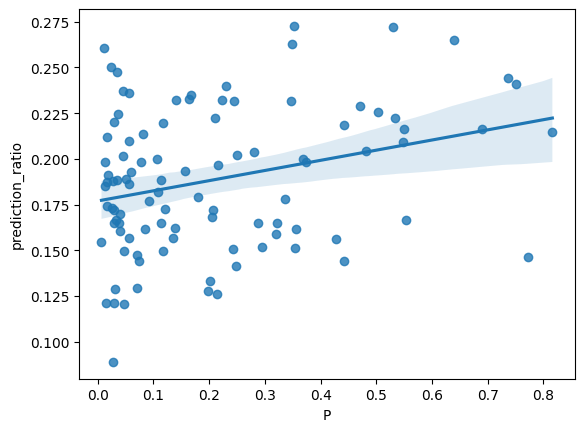

In [31]:
seaborn.regplot(data=summarized_df,x="P",y="prediction_ratio")

In [1]:
%pwd

'/Users/a626300/gitRepos/talks_and_tutorials/probabilistic_fairness'

## How Do We Know it Works?

### Tests on Simulated Data
![Graphs From Simulations](./supporting_files/simulation_graphs.png)

## Tests on Actual Data: Home Mortgate Disclosure Act 2018

The Home Mortgate Disclosure Act data is an open data file that contains mortgate originations, along with predictive features and the race of each individual. To test our model, we used the following steps:
1. Build a binary classifier for who received a mortgage.
1. Calculate fairness metrics using stated race (Oracle metric)
1. Calculate inferred metrics using zip code as our surrogate and US Census data to get probability for protected status (non-white) vs White. 

| Fairness Metric | Oracle Value | Inferred Value | Absolute Difference|
| --- | -: | -: | -: |
| Statistical Parity | -0.166 | -0.19 | 0.024 |
| Equal Opportunity | -0.085 | -0.110 | 0.025 |
| Predictive Equality | -0.102 | -0.094 | 0.008 |
| Predictive Equality | -0.093 | -0.102 | 0.007 |

## How is Probabilistic Fairness Different From What We Had Before?
The membership vector determines which type of fairness you're calculating. <br>
$membership=[0,1,0,0,...1]=>$ Deterministic fairness (we know for certain whether each person is in the protected group).<br>
$membership=[[0.1,0.9],[0.5,0.4],[0.7,0.3]...[0.0,1.0]] =>$ Probabilistic fairness. We have a probability of protected membership for each individual. <br>

For probabilistic fairness:
- membership must be a 2-D array or list. 
- The probabilities in membership must sum to 1. 

# What if I don't have a surrogate class?

Suppose we have a model that calculations the probability of protected membership but no surrogate class?

In [42]:
protected_predictions=pd.read_csv('~/Documents/data/jurity_tests/protected_predictions.csv')
print(protected_predictions.shape)
protected_predictions.head()

(9939, 2)


,UP,P
0,0.361378,0.638622
1,0.361378,0.638622
2,0.361378,0.638622
3,0.361378,0.638622
4,0.361378,0.638622


You can still calculate fairness statistics. Jurity will do the following:
1. Select the most likely group membership for each individual (argmax)
1. Use deterministic fairness methodology to calculate statistics based on group assignments.

In [43]:
#Put the membership vector into its appropriate form:
membership_predictions=protected_predictions.values.tolist()

In [45]:
print("Binary Fairness score, Statistical Parity: ", 
      metric.get_score(performance_data["prediction"], membership_predictions))

[0.361377542, 0.638622458]
<class 'list'>
False
Binary Fairness score, Statistical Parity:  0.03439820102798402


## Which Metrics Are Implemented?

There is some fun math behind the implementation that limits the metrics we're currently able to implement:
- Statistical Parity: Difference in prediction rate between protected and comparison group.
- Equal Opportunity: Difference in True Positive Rate between protected and comparison group.
- Predictive Equality: Difference in the False Positive Rate between protected and comparison group.
- Average Odds: Simple Mean of Equal Opportunity and Predictive Equality.
- FNR Difference: Difference in the False Negative Rates

Which one should you use? 
![Aequitas Fairness Tree](./supporting_files/Fairness-Short-Tree.png)

Source: <a href=https://arxiv.org/pdf/2001.09233.pdf>Rodolfa, Kit T., et al. "Case study: predictive fairness to reduce misdemeanor recidivism through social service interventions." Proceedings of the 2020 Conference on Fairness, Accountability, and Transparency. 2020.</a>

In [34]:
label_metrics={"Equal Opportunity": BinaryFairnessMetrics.EqualOpportunity(),
            "Predictive Equality": BinaryFairnessMetrics.PredictiveEquality(),
             "Average Odds": BinaryFairnessMetrics.AverageOdds(),
             "FNR Difference": BinaryFairnessMetrics.FNRDifference()}
no_label_metrics={"Statistical Parity":BinaryFairnessMetrics.StatisticalParity()}
print("Model Performance Using Probabilistic Membership, All Metrics\n")
for l,m in label_metrics.items():
    s=m.get_score(performance_data["label"],
                  performance_data["prediction"],
                  memberships,
                  performance_data["surrogate"],
               [0])
    print(f"\n{l}: {s}\n")
for l,m in no_label_metrics.items():
    s=m.get_score(performance_data["prediction"],
                  memberships,
                  performance_data["surrogate"],
               [0])
    print(f"\n{l}: {s}\n")

Model Performance Using Probabilistic Membership, All Metrics

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values

Equal Opportunity: 0.10723378263880878

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values

Predictive Equality: -0.035240696932145016

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values

Average Odds: 0.03724665224379154

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values

FNR Difference: -0.11983622266338502

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values

Statistical Parity: -0.05282251654425635



## "There are 9939 in performance_data. There are 99 in surrogate data.": What's this now?

Under the hood, Jurity does the following steps:
1. Summarize model performance by surrogate class (e.g. turn 'prediction' into 'prediction_ratio')
1. Join membership data, which has one row per surrogate class, with summarized data, on surrogate class.

Preparing data is often overlooked, but improperly prepared data can cause "silent errors", where the software produces output, but the output is wrong. Jurity runs light sanity checks on the inputs and surfaces some notes about the input data. 

In [46]:
# Suppose we lost the last 1000 rows of performance_data?
performance_whoops=performance_data.head(9000)
BinaryFairnessMetrics.EqualOpportunity().get_score(performance_whoops["label"],
                  performance_whoops["prediction"],
                  memberships,
                  performance_whoops["surrogate"],
               [0])

There are 9000 in performance_data.
There are 99 in surrogate data.
7 rows removed from datafame for insufficient weight values


0.1282206603030731

## "7 rows removed for insufficient weight values" What's This Now?
Recall the steps for surrogate clases: 
1. Summarize model performance by surrogate class (e.g. turn 'prediction' into 'prediction_ratio')
1. Join membership data, which has one row per surrogate class, with summarized data.

In the first, step, we turn "prediction" into "prediction_ratio" by calculating a mean.<br>
$$percentage=\frac{1}{n}\sum I(prediction==True)$$

This is a mean, and we want our means to stabilize so they're distributed $N(\mu, \frac{\sigma^2}{n})$<br>
This usually requires a sample size ($n$) of about 30 (central limit theorem). <br>
So, by default, we drop surrogate classes that have fewer than 30 predictions. 

"What if I want to use all of my data???" You can. See below--and we'll walk through this in detail in our sequel presentation on October 16. 

## How Do I Know This Works?

Details in the paper.<br> 
Short version: We calculated fairness metrics in cases where we knew the protected class status and compared against what we would have calculated if we'd only had surrogate class data. 

### Tests on Public Data: Home Mortgage Disclosure Act

### Tests on Simulated Data

## What Else Do I Need to Know?

Calculations are probabilistic and will change from run to run.

In [36]:
#Example: Calculate EqualOpportunity twice
print("EQ #1: ",BinaryFairnessMetrics.EqualOpportunity().get_score(performance_data["label"],
                  performance_data["prediction"],
                  memberships,
                  performance_data["surrogate"],
               [0]))
print("EQ #2: ",BinaryFairnessMetrics.EqualOpportunity().get_score(performance_data["label"],
                  performance_data["prediction"],
                  memberships,
                  performance_data["surrogate"],
               [0]))

There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values
EQ #1:  0.11439453392640975
There are 9939 in performance_data.
There are 99 in surrogate data.
0 rows removed from datafame for insufficient weight values
EQ #2:  0.11984933459467662


This is because we use bootstrap calculations, see <a href=https://www.hms.harvard.edu/bss/neuro/bornlab/nb204/statistics/bootstrap.pdf>Introduction to the Bootstrap</a>

How much do they change? Please attend our sequel presentation on October 16!

## Calculation Stability Depends on the Inputs
- A "wide range" of protected class probabilities
- A "large number" of surrogate classes
- A "large number" of individuals per surrogate class

### In Practical Terms
- Protected class probabilities should range from 0.1 to 0.9
- You should have at least 100 surrogate clases.
- You should have 20-30 individuals per surrogate class. 